# **函数式API**


### **引入**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



### **介绍**

Keras的函数式API是一种相对于Sequential API更为灵活地创建模型的方法。函数式API(把层当作函数来使用)可以处理非线性拓扑、共享层、多输入或输出的模型。

深度学习模型通常是层的有向无环图(DAG)结构，所以函数式API可以用来实现这样的需求。

我们先来思考下面的模型结构：


In [ ]:
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: 十个类别的对数概率分布值)

这是含有三个层的简单结构，我们下面使用函数式API来创建这个模型，首先创建一个输入节点。

In [ ]:
inputs = keras.Input(shape=(784,))

输入数据的形状被设置为一个784维的向量，这里我们只指定每个样本的形状，通常省略批量大小。


例如，如果用形状为(32,32,3)的图片数据作为输入，我们可以如下这样做：

In [ ]:
# 仅用于示例
img_input = keras.Input(shape=(32, 32, 3))

在前面的`inputs`中，包含了给模型输入数据的`shape`以及`dtype`，`shape`信息如下：

In [ ]:
inputs.shape

TensorShape([None, 784])

`dtype`信息如下：

In [ ]:
inputs.dtype

tf.float32

接下来创建一个新节点层，并用`inputs`作为输入调用该层：

In [ ]:
dense = layers.Dense(64, activation='relu')
x = dense(inputs)

这里“调用层”的操作类似前面模型结构那样，由`inputs`指向创建的层。通过将`inputs`传递给`dense`层，并将输出赋给x。

继续往结构中添加层：

In [ ]:
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10)(x)

到这一步为止，你可以创建一个模型，并指定输入和输出：

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')

现在我们查看一下模型的相关信息：

In [ ]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


你还可以将模型结构绘制成图：

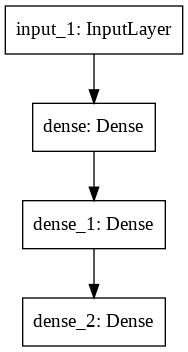

In [ ]:
keras.utils.plot_model(model, "my_fitst_model.png")

不仅如此，你还可以展现更详细的信息，包括每一层的输入和输出：

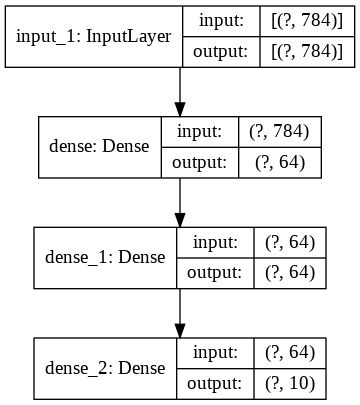

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

图中展现的结构与代码中构建的几乎相同，只不过将代码中的调用操作替换成了箭头指示。

“层的图形”是深度学习模型的直观影像，而函数式API就是以这种类似的方式创建模型。

### **训练，评估和预测**
对于函数式API模型和Sequential模型而言，它们的训练，评估和预测的工作方式基本相同。

接下来，我们首先加载[MNIST](http://yann.lecun.com/exdb/mnist/)数据集，并调整`shape`和`astype`，用于模型的训练(在验证集上监控性能)，然后在测试集上评估模型：

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=keras.optimizers.RMSprop(),
  metrics=['accuracy'],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/2
750/750 [==============================] - 3s 5ms/step - loss: 0.3546 - accuracy: 0.8981 - val_loss: 0.1940 - val_accuracy: 0.9453
Epoch 2/2
750/750 [==============================] - 3s 4ms/step - loss: 0.1699 - accuracy: 0.9490 - val_loss: 0.1433 - val_accuracy: 0.9589
313/313 - 1s - loss: 0.1397 - accuracy: 0.9583
Test loss: 0.1397070586681366
Test accuracy: 0.958299994468689


更多有关阅读，请参阅[训练和评估指南](https://www.tensorflow.org/guide/keras/train_and_evaluate/)。

### **保存和序列化**

对于函数式API模型和Sequential模型而言，它们的保存模型和序列化的工作方式基本相同。保存函数式模型的标准方法是调用`model.save()`将整个模型保存为单个文件。即使构建该模型的代码不再可用，你也可以从该文件重新创建相同的模型。

保存文件包括：
+ 模型的结构
+ 模型的权重值(已经在训练中学习到的)
+ 模型的训练配置(传递给`compile`)
+ 优化器和它的状态(将会在你中断出重新训练)

In [ ]:
model.save("path_to_my_model")
del model
# 仅通过模型文件创建一个完全相同的模型
model = keras.models.load_model("path_to_my_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: path_to_my_model/assets


更多细节，请参阅[序列化&保存](https://www.tensorflow.org/guide/keras/save_and_serialize/)指南


### **使用相同的层图定义多个模型**

在函数式API中，可以通过层图指定的输入和输出创建模型。这意味着一个层图可以用于生成多个模型。

在下面的例子中，你将会使用同一个层堆叠实例化两个模型：一个是将图像输入转换为16维向量的`encoder`模型，另一个是用于训练的端到端`autoencoder`模型。


In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPool2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

我们可以看到，解码与编码的结构严格对称，因此它们各自的输出形状与输入形状相同。

Conv2D层和Conv2DTranspose层相对，MaxPooling2D层和UpSampling2D层相对。

### **所有的模型都可以调用，就像层一样**

你可以像处理层那样，在输入和输出上调用模型。 通过调用模型，您不仅可以重用模型的体系结构，还可以重用其权重。 

为了进一步理解，下面将展示自动编码器的另一种处理方式，该示例创建一个编码器模型和一个解码器模型，并将它们通过链式调用得到输入输出，以此创建自动编码器模型：

In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

如你所见，模型可以嵌套：模型可以包含子模型(模型就像层一样)。模型嵌套的一个常见用例是*集成*。例如，以下是将一组模型合并一个模型，并将它们的平均预测作为输出：

In [ ]:
def get_model():
  inputs = keras.Input(shape=(128,))
  outputs = layers.Dense(1)(inputs)
  return keras.Model(inputs, outputs)

model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)

outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

### **处理复杂的图拓扑**

#### **拥有多输入和多输出的模型**

函数式API使得非常容易操作多输入和多输出的模型，这是`Sequential`API所办不到的。

例如，如果您要构建一个按优先级对定制票据排序，并将其匹配正确部门的系统，则该模型将具有三个输入：
+ 票据的抬头(文字输入)
+ 票据的文本正文(文字输入)
+ 人为添加的标签(分类输入)

该模型将具有两个输出：
+ 介于0和1之间的优先级分数(sigmoid的标量输出)
+ 负责票务的部门(部门的softmax输出)

通过函数式API，你只需要数行代码就可以完成创建该模型：

In [ ]:
num_tags = 12  # 标签数量
num_words = 10000  # 预处理文本数据的词汇量
num_departments = 4  # 预测的部分数量

title_input = keras.Input(
    shape=(None,), name="title"
)  # 可变长度的整数序列
body_input = keras.Input(shape=(None,), name="body")  # 可变长度的整数序列
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # 大小为`num_tags`的二进制向量

# 通过词嵌入层，每个标题单词将得到一个64维向量
title_features = layers.Embedding(num_words, 64)(title_input)
# 通过词嵌入层，每个正文文本单词将得到一个64维向量
body_features = layers.Embedding(num_words, 64)(body_input)

# 通过LSTM层，将得到的标题词嵌入向量压缩到128维的向量中
title_features = layers.LSTM(128)(title_features)
# 通过LSTM层，将得到的文本正文词嵌入向量压缩到32维的向量中
body_features = layers.LSTM(32)(body_features)

#通过`concatenate`将所有可用特征合并到一个大的向量中
x = layers.concatenate([title_features, body_features, tags_input])

# 将优先级预测的逻辑回归层连接到特征之上
priority_pred = layers.Dense(1, name="priority")(x)
# 将部门分类器连接到特征之上
department_pred = layers.Dense(num_departments, name="department")(x)

# 实例化预测优先级和部门的端到端模型
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

现在我们来绘制模型：

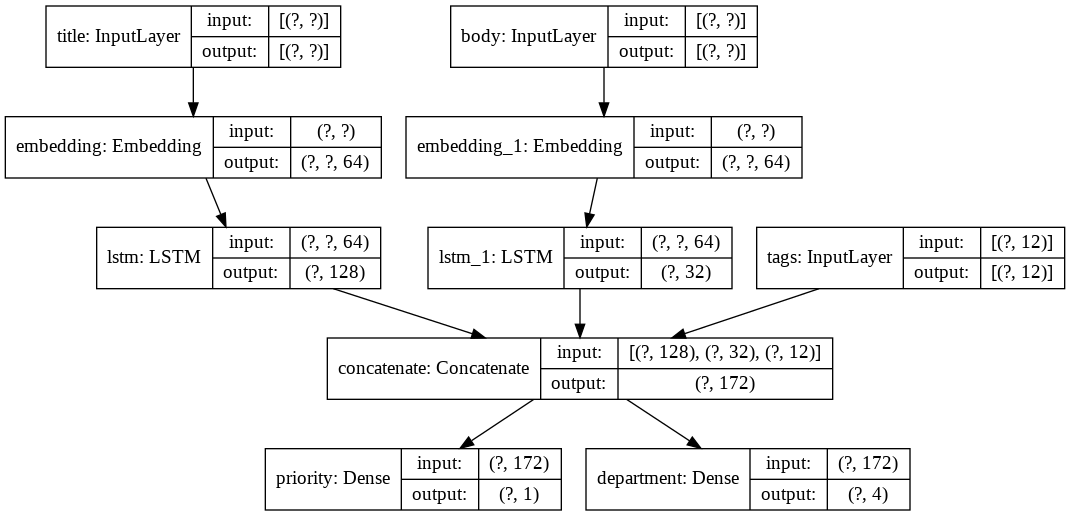

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

编译此模型时，可以为每个输出分配不同的损失函数。你甚至可以为每个损失值分配不同的权重--调整它们各自对总训练损失的影响。

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

由于输出层具有不同的名称，因此你还可以通过以下的方式指定损失函数：

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

通过传入输入和目标的NumPy数组列表来训练模型：

In [ ]:
# 创建模拟输入数据
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# 创建模拟目标数据
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 1s 34ms/step - loss: 1.2887 - priority_loss: 0.7045 - department_loss: 2.9210
Epoch 2/2
40/40 [==============================] - 1s 34ms/step - loss: 1.2811 - priority_loss: 0.6976 - department_loss: 2.9175


当使用`Dataset`对象调用`fit`时，它应产生一个列表元组，例如`([title_data，body_data，tags_data]，[priority_targets，dept_targets])`或一个字典元组，例如`({'title'：title_data，'body'： body_data，“标签”：tags_data}，{“优先级”：priority_targets，“部门”：dept_targets})`。

有关详细说明，请参阅[训练和评估](https://www.tensorflow.org/guide/keras/train_and_evaluate/)指南。

#### **ResNet 模型**
除了方便构建拥有多个输入和输出的模型之外，函数式API也使得处理非线性拓扑连接变得容易--这些模型的层不是按照顺序连接的。`Sequential`API无法处理这样的模型结构。

一个常见的例子是残差连接。为了演示如何工作的，接下来我们将通过CIFAR10来创建一个ResNet模型：

In [ ]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

# 这里padding是扩展图像边缘的操作，可以理解为valid导致图像变小，same导致边缘变黑

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_9[0][0]                   
_________________________________________________________________________________________

绘制模型图层

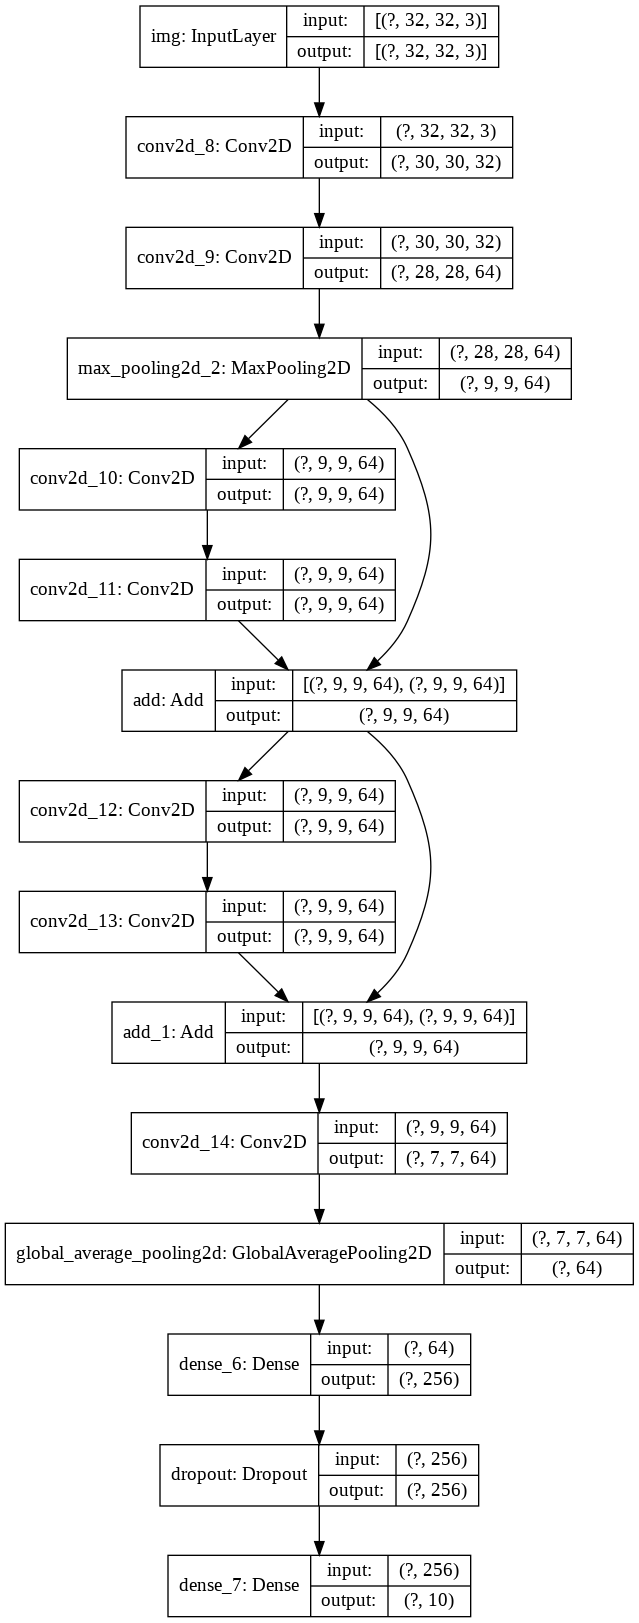

In [ ]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

现在训练模型

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# 我们将数据限制为前1000个样本，节省执行时间
# 以Colab上运行为例，对整个数据集进行训练，直到收敛为止！
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

13/13 [==============================] - 1s 57ms/step - loss: 2.3060 - acc: 0.1163 - val_loss: 2.2957 - val_acc: 0.1100


### **共享层**

函数式API的另一个很好的用途是使用共享层的模型。共享层是在同一模型中多次重用的层实例--它们学习层图中的多个流程路径相对应的特征。

共享层通常用于编码有着相似空间的输入(例如，两个具有相似词汇的不同文本)。它们可以在这些不同的输入之间共享信息，并且可以在更少的数据上训练这种模型。 如果在输入之一中看到给定的单词，这将有利于处理通过共享层的所有输入。

为了在函数式API中实现共享层的操作，在下面例子中，将多次调用同一个层的实例，即在两个不同的文本输入之间共享的`Embedding`层：

In [ ]:
# 通过词嵌入层，将1000个不同的单词映射得到一个128维向量
shared_embedding = layers.Embedding(1000, 128)

# 可变长度整数序列
text_input_a = keras.Input(shape=(None,), dtype="int32")

# 可变长度整数序列
text_input_b = keras.Input(shape=(None,), dtype="int32")

# 重用同一个层来编码两个输入
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

### **提取和重用层图中的节点**

由于我们要处理的层图是静态数据结构，因此可以对其进行访问和检查，这就是将函数式模型绘制为图像的方式。

这也意味着您可以访问中间层的激活(即图中的“节点”)，并在其他需要的地方重用它们--这对于诸如特征提取之类的操作非常有用。

让我们来看一个例子。这是一个VGG19模型，其权重在ImageNet上进行了预训练：

In [ ]:
vgg19 = tf.keras.applications.VGG19()

574717952/574710816 [==============================] - 6s 0us/step


下面是通过查询图形数据结构，获得模型的中间激活：

In [ ]:
features_list = [layer.output for layer in vgg19.layers]

使用提取的特征来创建新的模型，该模型返回中间层激活的值：

In [ ]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)

这尤其适用于诸如[神经风格迁移](https://www.tensorflow.org/tutorials/generative/style_transfer)之类的任务。

### **使用自定义层扩展API**

[tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras)包含各种内置层，例如：
+ 卷积层：`Conv1D`,`Conv2D`,`Conv3D`,`Conv2DTranspose`
+ 池化层：`MaxPooling1D`,`MaxPooling2D`,`MaxPooling3D`,`AveragePooling1D`
+ RNN层：`GRU`,`LSTM`,`ConvLSTM2D`
+ `BatchNormalization`,`Dropout`,`Embedding`等等

但是，如果找不到合适的层，则可以通过创建自己的层来扩展API。所有层都继承了`Layer`类并实现如下方法：
+ `call`方法，它指定由层完成的计算
+ `build`方法，创建图层的权重(这只是一种风格约定，因为你也可以在__init__中创建权重)

要了解有关从头开始创建层的更多信息，请阅读[自定义层和模型](https://www.tensorflow.org/guide/keras/custom_layers_and_models)指南。

以下是`tf.keras.layers.Dense`的基本实现：

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

为了在自定义层中能够支持序列化，需要定义一个`get_config`方法，该方法返回该层实例的构造函数参数：

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})

可以选择性的实现类方法`from_config(cls，config)`，该方法在给定其config字典的情况下，将重新创建层实例时使用。`from_config`的默认实现是：

In [ ]:
def from_config(cls, config):
  return cls(**config)

### **何时使用函数式API**

何时应该使用Keras函数式API创建新模型？或者仅直接对`Model`类进行子类化？通常情况下，函数式API相对更高级，更容易且更安全的API，并且具有许多子类化模型不支持的特性。

然而，当构建不容易表示为有向无环图的模型时，模型子类化提供了更大的灵活性。例如，你无法使用函数式API来实现`Tree-RNN`，而必须直接继承`Model`。

要深入了解函数式API和模型子类化之间的区别，请参阅[TensorFlow2.0中，什么是符号API和命令式API](https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html)。

#### 函数式API的优势
以下属性对于Sequential模型(也是数据结构)也适用，但对于子类化模型(Python字节码而非数据结构)则不适用。

**更少冗余**

函数式API没有`super(MyClass, self).__init__(...)`以及`def call(self, ...):`等。

下面我们来对两者进行对比，首先是函数式API：

In [ ]:
inputs = keras.Input(shape=(32,))
x = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10)(x)
mlp = keras.Model(inputs, outputs)

下面是子类化的版本：

In [ ]:
class MLP(keras.Model):

  def __init__(self, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

# 实例化模型
mlp = MLP()
# 需要创建模型状态
# 在第一次调用之前，该模型没有状态
_ = mlp(tf.zeros((1, 32)))

**定义连接图时进行模型验证**

在函数式API中，输入规范(shape和dtype)是预先创建的(使用Input)。每次调用层时，该层都会检查传递给它的规范是否符合其预期，如果不符合，它将触发有用的错误消息。

这样可以保证使用函数式API构建的任何模型都可以运行。除与收敛有关的调试外，所有调试均在模型构建过程中静态地进行，而不是在执行时进行。这类似于编译器中的类型检查。

**函数式模型是可绘制和可检查的**

你可以将模型绘制为图形，并且可以轻松访问此图形中的中间节点。例如，要提取并重用中间层的激活(如前面的示例所示)：


In [ ]:
features_list = [layer.output for layer in vgg19.layers]
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

**函数式模型可以序列化或克隆**

因为函数式模型是数据结构而不是一段代码，所以它可以安全地序列化，并且可以保存为单个文件，从而使得你可以重新创建完全相同的模型，而无需访问任何原始代码。请参阅[序列化和保存](https://www.tensorflow.org/guide/keras/save_and_serialize/)指南。

要序列化子类化的模型，需要在实现的类中实现指定`get_config()`和`from_config()`方法。

#### **函数式API的缺点：**

**它不支持动态架构**

函数式API将模型视为层的有向无环图(DAG)。对于大多数深度学习架构而言，这是正确的，但并非所有情况都是如此。例如，递归网络或Tree RNN不遵循此假设，并且无法在函数式API中实现。

### **混搭API风格**

值得注意的是，在函数式API或模型子类化之间进行选择，并不是将你限制在这两种选择的二选一中。 [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras)API中的所有模型都可以彼此交互，无论它们是`Sequential`模型，函数式模型还是自定义的子类化模型。

你始终可以将函数式模型或`Sequential`模型用作子类化模型或层的一部分：

In [ ]:
units = 32
timesteps = 10
input_dim = 5

# Define a Functional model
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        # Our previously-defined Functional model
        self.classifier = model

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

你可以在函数式API中使用任何子类化的层或模型，只要它的`call`方法遵循以下模式中的一个即可：

+ `call(self，inputs，** kwargs)`--`inputs`是张量或张量的嵌套结构(例如张量列表)，而`** kwarg`是非张量参数(非输入)。

+ `call(self，inputs，training = None，** kwargs)`--其中`training`是一个布尔值，指示该层是否应在训练模式和预测模式下运行。
+ `call(self，inputs，mask = None，** kwargs)`--其中`mask`是一个布尔值的掩码张量（例如，它对RNN有用）。

+ `call(self, inputs, training=None, mask=None, **kwargs)`--当然，你可以同时具有掩码和特定训练的模式。

此外，如果在自定义层或模型上实现`get_config`方法，则创建的函数式模型仍将可序列化和克隆。

下面展示在函数式模型中，使用的从头开始编写的自定义RNN示例：

In [ ]:
units = 32
timesteps = 10
input_dim = 5
batch_size = 16


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        self.classifier = layers.Dense(1)

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        return self.classifier(features)


# Note that you specify a static batch size for the inputs with the `batch_shape`
# arg, because the inner computation of `CustomRNN` requires a static batch size
# (when you create the `state` zeros tensor).
inputs = keras.Input(batch_shape=(batch_size, timesteps, input_dim))
x = layers.Conv1D(32, 3)(inputs)
outputs = CustomRNN()(x)

model = keras.Model(inputs, outputs)

rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, 10, 5)))